# Описание проекта

Заказчик - Яндекс.  
Необходимо проанализировать активность в чатах Пачки и Слак.  
Основная проблема – низкая обратная связь на важные посты, публикуемые в чатах
Задачи: проанализировать поведение студентов в чатах; выявить паттерны, динамику, цикличность в течение дня, недели, месяца, года; визуализировать свои находки; помочь нам понять, когда активность студентов в чатах наибольшая, и когда лучше публиковать посты/анонсы, чтобы получить больше откликов; проанализировать различные типы каналов, когорт, групп; оценить в каких общения больше, в каких меньше, и как они различаются от когорты к когорте, от канала к каналу.
# Данные
`Unnamed: 0` - индекс;  
`client_msg_id` - id сообщения;  
`type` - тип поста;  
`user` - id пользователя;  
`ts` - дата поста;  
`thread_ts` - дата треда;  
`latest_reply` - дата ответа;  
`team` - факт вхождения в неизвестную группу;  
`subtype` - метка действий пользователя;  
`channel` - канал;  
`file_date` - дата файла;  
`attachments` - прикреплённые файлы;  
`reactions` - реакции;  
`text_len` - длина текста сообщения;  
`text_words` - количество слов в сообщении.


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import io
import math
import re
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

In [ ]:
# запуск с локального диска
#from google.colab import files
#uploaded = files.upload()
#df = pd.read_csv(io.BytesIO(uploaded['chat_data_clean.csv']))

# Предобработка данных

In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/Личное/Analitic data/Проекты/Мастерская/chat_data_clean.csv')
#df.head()

In [ ]:
try:
    df = pd.read_csv('/content/drive/MyDrive/Личное/Analitic data/Проекты/Мастерская/chat_data_clean.csv')
except:
    df = pd.read_csv('/content/drive/MyDrive/datasets/chat_data_clean.csv')
#
df.head(3)

,Unnamed: 0,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words
0,0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,1.669643e+09,1.669645e+09,TPV9DP0N4,1.669643e+09,NaN,data-analysts-bus,2022-11-28,0,NaN,297,47
1,1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,1.669645e+09,NaN,TPV9DP0N4,1.669643e+09,NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'c...",434,63
2,2,NaN,message,U02KVQJHQ5S,1.669647e+09,NaN,NaN,NaN,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26533 entries, 0 to 26532
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     26533 non-null  int64  
 1   client_msg_id  18262 non-null  object 
 2   type           26533 non-null  object 
 3   user           23643 non-null  object 
 4   ts             26533 non-null  float64
 5   latest_reply   2303 non-null   float64
 6   team           15857 non-null  object 
 7   thread_ts      18222 non-null  float64
 8   subtype        8317 non-null   object 
 9   channel        26533 non-null  object 
 10  file_date      26533 non-null  object 
 11  attachments    26533 non-null  int64  
 12  reactions      4169 non-null   object 
 13  text_len       26533 non-null  int64  
 14  text_words     26533 non-null  int64  
dtypes: float64(3), int64(4), object(8)
memory usage: 3.0+ MB


In [ ]:
print(df.isna().sum()) # ищем пропущенные значения
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm') # выводим % пропусков

Unnamed: 0           0
client_msg_id     8271
type                 0
user              2890
ts                   0
latest_reply     24230
team             10676
thread_ts         8311
subtype          18216
channel              0
file_date            0
attachments          0
reactions        22364
text_len             0
text_words           0
dtype: int64


,0
Unnamed: 0,0.000000
client_msg_id,31.000000
type,0.000000
user,11.000000
ts,0.000000
latest_reply,91.000000
team,40.000000
thread_ts,31.000000
subtype,69.000000
channel,0.000000


По пропущенным значениям:    
client_msg_id - id сообщений - 31 % пропусков;    
latest_reply - дата ответа - 91 % пропусков;    
team - факт вхождения в неизвестную группу - 40 % пропусков;    
thread_ts - дата треда - 31% пропусков;    
subtype - метка действий пользователя - 69% пропусков;    
reactions - реакции - 84% пропусков.    


In [ ]:
print('Явных дубликатов:', df.duplicated().sum()) # проверяем на наличие явных дубликатов

Явных дубликатов: 0


In [ ]:
# преобразуем типы данных
df['ts'] = pd.to_datetime(df['ts'], unit='s')
df['ts'] = pd.to_datetime(df['ts'], format = "%Y%m%d").dt.strftime('%Y-%m-%d, %H:%M:%S')

In [ ]:
df['latest_reply'] = pd.to_datetime(df['latest_reply'], unit='s')
df['latest_reply'] = pd.to_datetime(df['latest_reply'], format = "%Y%m%d").dt.strftime('%Y-%m-%d, %H:%M:%S')

In [ ]:
df['thread_ts'] = pd.to_datetime(df['thread_ts'], unit='s')
df['thread_ts'] = pd.to_datetime(df['thread_ts'], format = "%Y%m%d").dt.strftime('%Y-%m-%d, %H:%M:%S')

In [ ]:
df['file_date'] = pd.to_datetime(df['file_date'])

In [ ]:
# почему-то не изменился тип данных, только преобразовал, делаем в ручную
df['ts'] = pd.to_datetime(df['ts'])
df['latest_reply'] = pd.to_datetime(df['latest_reply'])
df['thread_ts'] = pd.to_datetime(df['thread_ts'])

In [ ]:
# проверяем изменения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26533 entries, 0 to 26532
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     26533 non-null  int64         
 1   client_msg_id  18262 non-null  object        
 2   type           26533 non-null  object        
 3   user           23643 non-null  object        
 4   ts             26533 non-null  datetime64[ns]
 5   latest_reply   2303 non-null   datetime64[ns]
 6   team           15857 non-null  object        
 7   thread_ts      18222 non-null  datetime64[ns]
 8   subtype        8317 non-null   object        
 9   channel        26533 non-null  object        
 10  file_date      26533 non-null  datetime64[ns]
 11  attachments    26533 non-null  int64         
 12  reactions      4169 non-null   object        
 13  text_len       26533 non-null  int64         
 14  text_words     26533 non-null  int64         
dtypes: datetime64[ns](4

In [ ]:
print('Явных дубликатов:', df.duplicated().sum())

Явных дубликатов: 0


In [ ]:
# смотрим уникальные значения
df['type'].unique()

array(['message'], dtype=object)

In [ ]:
df['team'].unique()

array(['TPV9DP0N4', nan], dtype=object)

In [ ]:
df['subtype'].unique()

array([nan, 'channel_join', 'bot_remove', 'thread_broadcast',
       'channel_unarchive', 'channel_leave', 'bot_message',
       'channel_purpose', 'tombstone', 'channel_name'], dtype=object)

In [ ]:
# смотрим на уникальные значения
df['channel'].unique()

array(['data-analysts-bus', 'datatracker_logs', 'data_complaints',
       'data_edteam_info', 'da_42_exerciser_1', 'da_42_exerciser_2',
       'da_42_projects_1', 'da_42_projects_2', 'da_50_info',
       'da_50_library', 'da_50_teamwork', 'da_52_exerciser', 'da_52_info',
       'da_52_library', 'da_52_projects', 'da_52_teamwork',
       'da_53_exerciser_1', 'da_53_exerciser_2', 'da_53_info',
       'da_53_library', 'da_53_projects_1', 'da_53_projects_2',
       'da_53_teamwork', 'da_54_exerciser_01', 'da_54_exerciser_02',
       'da_54_info', 'da_54_library', 'da_54_projects_01',
       'da_54_projects_02', 'da_54_teamwork', 'da_55_exerciser',
       'da_55_info', 'da_55_library', 'da_55_projects', 'da_55_teamwork',
       'da_56b_exerciser', 'da_56b_info', 'da_56b_library',
       'da_56b_projects', 'da_56b_teamwork', 'da_56_exerciser_1',
       'da_56_exerciser_2', 'da_56_info', 'da_56_library',
       'da_56_projects_1', 'da_56_projects_2', 'da_56_teamwork',
       'da_58_digitalpro

In [ ]:
df['attachments'].unique()

array([0, 1, 2, 3, 4, 5])

In [ ]:
df['reactions'].unique()

array([nan, "[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'count': 1}]",
       "[{'name': 'cat-high-five', 'users': ['U040E2D6CF2'], 'count': 1}]",
       ..., "[{'name': 'pray', 'users': ['U03RSC0RSBU'], 'count': 1}]",
       "[{'name': 'cat-high-five', 'users': ['U02QK4VR38F'], 'count': 1}]",
       "[{'name': 'cat-high-five', 'users': ['U044T2TLGH3'], 'count': 1}]"],
      dtype=object)

In [ ]:
# выделяем месяцы, дни недели, часы
df['ts_year'] = df['ts'].dt.year #выделяем год
df['ts_month'] = df['ts'].dt.month #выделяем месяцы
df['ts_week_day'] = df['ts'].dt.weekday # выделяем день недели
df['ts_hours'] = df['ts'].dt.hour #выделяем час

In [ ]:
df['ts_year'].unique() # данные предоставлены за 22 и 23 год

array([2022, 2023])

In [ ]:
df['ts_month'].unique() # данные представлены с октября по февраль
def month(row):
  wd = row['ts_month']
  if wd == 1:
    return 'Январь'
  if wd == 2:
    return 'Февраль'
  if wd == 3:
    return 'Март'
  if wd == 4:
    return 'Апрель'
  if wd == 5:
    return 'Май'
  if wd == 6:
    return 'Июнь'
  if wd == 7:
    return 'Июль'
  if wd == 8:
    return 'Август'
  if wd == 9:
    return 'Сентябрь'
  if wd == 10:
    return 'Октябрь'
  if wd == 11:
    return 'Ноябрь'
  if wd == 12:
    return 'Декабрь'
df['ts_month'] = df.apply(month, axis = 1)

In [ ]:
# переименовываем дни недели
def week_day(row):
  wd = row['ts_week_day']
  if wd == 0:
    return '1_Понедельник'
  if wd == 1:
    return '2_Вторник'
  if wd == 2:
    return '3_Среда'
  if wd == 3:
    return '4_Четверг'
  if wd == 4:
    return '5_Пятница '
  if wd == 5:
    return '6_Суббота'
  if wd == 6:
    return '7_Воскресенье'
df['ts_week_day'] = df.apply(week_day, axis = 1)

In [ ]:
df['ts_week_day'].unique()

array(['1_Понедельник', '2_Вторник', '3_Среда', '4_Четверг', '5_Пятница ',
       '6_Суббота', '7_Воскресенье'], dtype=object)

In [ ]:
# выделяем интервалы времени
def hours(row):
  h = row['ts_hours']
  if h in [0, 1, 2]:
    return '00:00 - 03:00'
  if h in [3, 4, 5]:
    return '03:00 - 06:00'
  if h in [6, 7, 8]:
    return '06:00 - 09:00'
  if h in [9, 10, 11]:
    return '09:00 - 12:00'
  if h in [12, 13, 14]:
    return '12:00 - 15:00'
  if h in [15, 16, 17]:
    return '15:00 - 18:00'
  if h in [18, 19, 20]:
    return '18:00 - 21:00'
  if h in [21, 22, 23]:
    return '21:00 - 00:00'
  return h
df['ts_hours'] = df.apply(hours, axis = 1)

In [ ]:
df['ts_hours'].unique()

array(['12:00 - 15:00', '06:00 - 09:00', '09:00 - 12:00', '18:00 - 21:00',
       '15:00 - 18:00', '03:00 - 06:00', '21:00 - 00:00', '00:00 - 03:00'],
      dtype=object)

In [ ]:
def sum_reactions(name):
  try:
    a = name
    b = re.findall(r"count\': (\d+)", a)
    l = []
    for ch in b:
      if ch.isdigit():
        l.append(int(ch))
    return sum(l)
  except:
    return 0
df['count_reactions'] = df['reactions'].apply(sum_reactions)


In [ ]:
df.head(10)

,Unnamed: 0,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words,ts_year,ts_month,ts_week_day,ts_hours
0,0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,2022-11-28 13:49:23,2022-11-28 14:24:08,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,0,NaN,297,47,2022,Ноябрь,1_Понедельник,12:00 - 15:00
1,1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,2022-11-28 14:24:08,NaT,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'c...",434,63,2022,Ноябрь,1_Понедельник,12:00 - 15:00
2,2,NaN,message,U02KVQJHQ5S,2022-11-28 14:48:50,NaT,NaN,NaT,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5,2022,Ноябрь,1_Понедельник,12:00 - 15:00
3,3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,2022-11-29 08:08:12,2022-11-29 10:56:57,NaN,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U040E2D6...",69,12,2022,Ноябрь,2_Вторник,06:00 - 09:00
4,4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,2022-11-29 08:32:32,NaT,TPV9DP0N4,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,NaN,19,2,2022,Ноябрь,2_Вторник,06:00 - 09:00
5,5,NaN,message,U0421JZP400,2022-11-29 10:19:47,NaT,NaN,NaT,channel_join,data-analysts-bus,2022-11-29,0,NaN,37,5,2022,Ноябрь,2_Вторник,09:00 - 12:00
6,6,NaN,message,U02Q4P6SGBC,2022-11-29 10:19:47,NaT,NaN,NaT,channel_join,data-analysts-bus,2022-11-29,0,NaN,37,5,2022,Ноябрь,2_Вторник,09:00 - 12:00
7,7,6a730fa5-7934-41f4-96f0-aa04787bce8e,message,U03DZHHUACW,2022-11-29 10:26:46,2022-11-29 12:08:01,TPV9DP0N4,2022-11-29 10:26:46,NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U0421JZP...",469,48,2022,Ноябрь,2_Вторник,09:00 - 12:00
8,8,19e7fd69-a6d9-42aa-acbf-722eebe78fc6,message,U03JYMWQLP5,2022-11-29 10:55:25,NaT,NaN,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,NaN,42,6,2022,Ноябрь,2_Вторник,09:00 - 12:00
9,9,031b6894-db20-4844-91e4-7c6324351365,message,U040E2D6CF2,2022-11-29 10:56:57,NaT,TPV9DP0N4,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'c...",6,1,2022,Ноябрь,2_Вторник,09:00 - 12:00


In [ ]:
# выделяем названия когорт
df['cogorts'] = df['channel'].str.replace('-', '_') # приводим к единому типу
df['cogorts'] = df['cogorts'].str.split('_', 2).str[0]
def cogorts_name(row):
  names = ['data', 'datatracker', 'design', 'donorsearch', 'masterskaya']
  cn = row['cogorts']
  if cn in names:
    return 'other'
  return cn
df['cogorts'] = df.apply(cogorts_name, axis = 1)
df['cogorts'].unique()

<ipython-input-32-fbcaf19aaa34>:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df['cogorts'] = df['cogorts'].str.split('_', 2).str[0]


array(['other', 'da', 'de', 'dl', 'ds', 'sql'], dtype=object)

In [ ]:
pd.set_option('display.max_columns', 30)
df.head()

,Unnamed: 0,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words,ts_year,ts_month,ts_week_day,ts_hours,count_reactions,cogorts
0,0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,2022-11-28 13:49:23,2022-11-28 14:24:08,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,0,NaN,297,47,2022,Ноябрь,1_Понедельник,12:00 - 15:00,0,other
1,1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,2022-11-28 14:24:08,NaT,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'c...",434,63,2022,Ноябрь,1_Понедельник,12:00 - 15:00,1,other
2,2,NaN,message,U02KVQJHQ5S,2022-11-28 14:48:50,NaT,NaN,NaT,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5,2022,Ноябрь,1_Понедельник,12:00 - 15:00,0,other
3,3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,2022-11-29 08:08:12,2022-11-29 10:56:57,NaN,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U040E2D6...",69,12,2022,Ноябрь,2_Вторник,06:00 - 09:00,1,other
4,4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,2022-11-29 08:32:32,NaT,TPV9DP0N4,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,NaN,19,2,2022,Ноябрь,2_Вторник,06:00 - 09:00,0,other


In [ ]:
# выделяем каналы
df['channel_groups'] = df['channel']
def ch_groups(row):
  chg = row['channel_groups']
  if 'project' in chg:
    return 'projects'
  if 'teamwork' in chg:
    return 'teamwork'
  if 'info' in chg:
    return 'info'
  if 'employment' in chg:
    return 'employment'
  if 'library' in chg:
    return 'library'
  if 'exerciser' in chg:
    return 'exerciser'
  return 'other'
df['channel_groups'] = df.apply(ch_groups, axis = 1)
df['channel_groups'].unique() # проверяем результат

array(['other', 'info', 'exerciser', 'projects', 'library', 'teamwork'],
      dtype=object)

# Предоставление результатов

In [ ]:
df.head() # получившийся датафрейм

,Unnamed: 0,client_msg_id,type,user,ts,latest_reply,team,thread_ts,subtype,channel,file_date,attachments,reactions,text_len,text_words,ts_year,ts_month,ts_week_day,ts_hours,count_reactions,cogorts,channel_groups
0,0,ae31e785-257b-4290-a4c6-9721337f67ea,message,U03JYMWQLP5,2022-11-28 13:49:23,2022-11-28 14:24:08,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,0,NaN,297,47,2022,Ноябрь,1_Понедельник,12:00 - 15:00,0,other,other
1,1,7f644ae8-16d4-4c9e-9c4f-8b2d6df6a28d,message,U03V483FRKM,2022-11-28 14:24:08,NaT,TPV9DP0N4,2022-11-28 13:49:23,NaN,data-analysts-bus,2022-11-28,0,"[{'name': 'pray', 'users': ['U03JYMWQLP5'], 'c...",434,63,2022,Ноябрь,1_Понедельник,12:00 - 15:00,1,other,other
2,2,NaN,message,U02KVQJHQ5S,2022-11-28 14:48:50,NaT,NaN,NaT,channel_join,data-analysts-bus,2022-11-28,0,NaN,37,5,2022,Ноябрь,1_Понедельник,12:00 - 15:00,0,other,other
3,3,6c5bf2c1-8579-413c-8e8f-ec3a0e3698a8,message,U03JYMWQLP5,2022-11-29 08:08:12,2022-11-29 10:56:57,NaN,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,"[{'name': 'cat-high-five', 'users': ['U040E2D6...",69,12,2022,Ноябрь,2_Вторник,06:00 - 09:00,1,other,other
4,4,b5e3413b-8f04-4192-948b-2423eb3192b2,message,U040E2D6CF2,2022-11-29 08:32:32,NaT,TPV9DP0N4,2022-11-29 08:08:12,NaN,data-analysts-bus,2022-11-29,0,NaN,19,2,2022,Ноябрь,2_Вторник,06:00 - 09:00,0,other,other


In [ ]:
# смотрим на действия пользователей
df.groupby('subtype')['subtype'].count()

subtype
bot_message          2890
bot_remove              1
channel_join         2026
channel_leave        3265
channel_name            1
channel_purpose         2
channel_unarchive      10
thread_broadcast      108
tombstone              14
Name: subtype, dtype: int64

**Вывод:**  
Интересно будет поработать со столбцами **channel_join** и **channel_leave**

In [ ]:
# анализ количества пользователей по месяцам
# получаем общее количество пользователей по когортам за вычетом пропущенных позиций по user:
df_users = df.query('user != "Nan"') # исключаем пропущенных user
df_users_graf = df_users.groupby('ts_month').agg({'user' : 'nunique'}).reset_index().sort_values(by = 'user', ascending = False)
df_users_graf

,ts_month,user
0,Декабрь,2487
1,Ноябрь,1400
2,Октябрь,2
3,Февраль,2
4,Январь,1


In [ ]:
#код ревьюера

#сравним размер датафрейма при разных формах запроса
df.query('user != "Nan"').shape[0], df.query('not user.isna()').shape[0]

(26533, 23643)

**Вывод:**  
Максимальное количество пользователей находилось в чате в ноябре и декабре. Октябрь, январь и февраль можно не брать в расчет.

In [ ]:
# когда чаще всего заходили (subtype) по годам
channel_join_year = df.query('subtype == "channel_join"').pivot_table(index = 'ts_year', values = 'subtype', aggfunc = 'count').reset_index()
display(channel_join_year)

,ts_year,subtype
0,2022,2016
1,2023,10


**Вывод:**  
Чаще всего в чат заходили в 2022 году.

In [ ]:
sns.set() # строим оси

,ts_month,ts
0,Декабрь,18322
1,Ноябрь,8180
4,Январь,14
3,Февраль,10
2,Октябрь,7


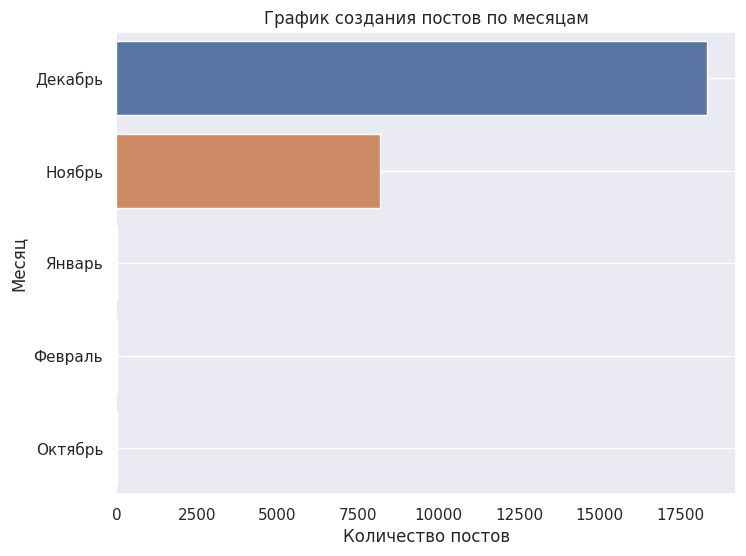

In [ ]:
# анализ постов по месяцам:
posts_month = df.groupby('ts_month')['ts'].count().reset_index().sort_values(by = 'ts', ascending = False)
display(posts_month) # количество постов по месяцам
# строим диаграмму по количеству постов по месяцам
plt.figure(figsize=(8, 6)) # Размер графика
plt.title('График создания постов по месяцам') # Название графика
sns.barplot(x='ts', y='ts_month', data=posts_month).set(ylabel='Месяц', xlabel='Количество постов')
plt.grid()
plt.show()

**Вывод:**  
Основная масса постов создается в ноябре и декабре.

,ts_month,thread_ts
0,Декабрь,13510
1,Ноябрь,4705
2,Октябрь,7
3,Февраль,0
4,Январь,0


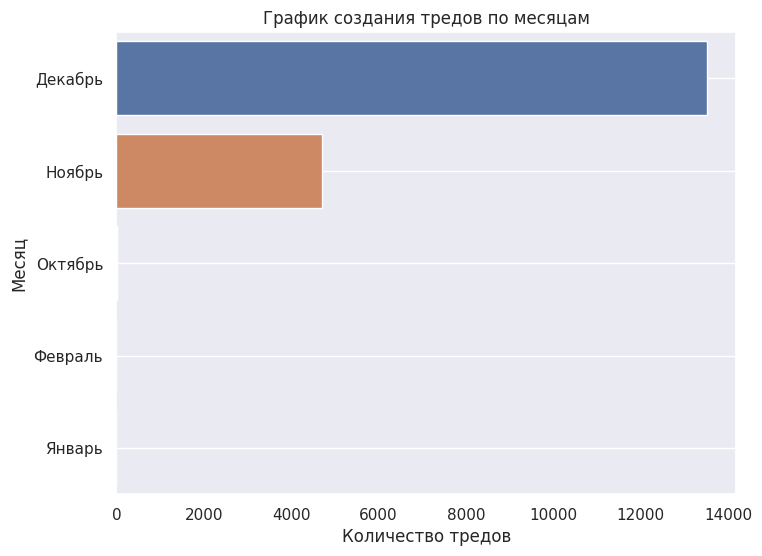

In [ ]:
# анализ тредов по месяцам
treds_month = df.groupby('ts_month')['thread_ts'].count().reset_index().sort_values(by = 'thread_ts', ascending = False)
display(treds_month) # количество тредов по месяцам
# строим диаграмму по количеству тредов по месяцам
plt.figure(figsize=(8, 6)) # Размер графика
plt.title('График создания тредов по месяцам') # Название графика
sns.barplot(x='thread_ts', y='ts_month', data = treds_month).set(ylabel='Месяц', xlabel='Количество тредов')
plt.grid()
plt.show()

**Вывод:**  
Основная масса тредов создается в ноябре и декабре.

,ts_month,count_reactions
0,Декабрь,7460
1,Ноябрь,3700
2,Октябрь,0
3,Февраль,0
4,Январь,0


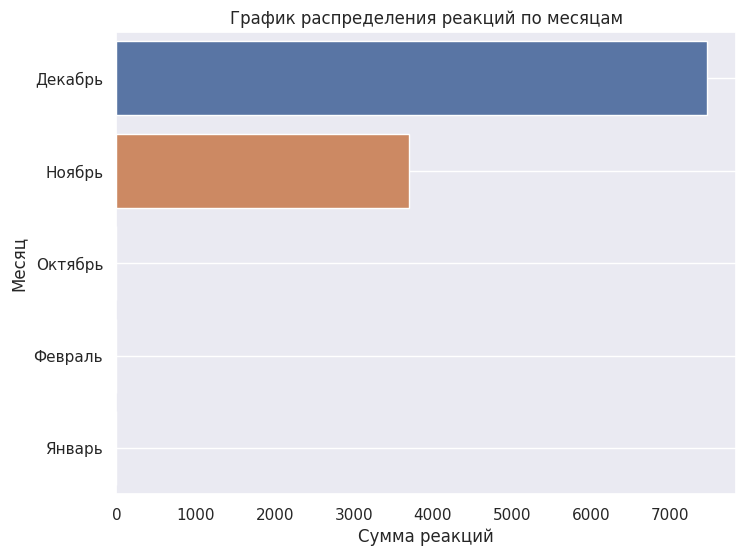

In [ ]:
# анализ количества реакций по месяцам
reactions_month = df.groupby('ts_month')['count_reactions'].sum().reset_index().sort_values(by = 'count_reactions', ascending = False)
display(reactions_month) # сумма реакций по месяцам
# строим диаграмму по сумме реакций по месяцам
plt.figure(figsize=(8, 6)) # Размер графика
plt.title('График распределения реакций по месяцам') # Название графика
sns.barplot(x='count_reactions', y='ts_month', data=reactions_month).set(ylabel='Месяц', xlabel='Сумма реакций')
plt.grid()
plt.show()

**Вывод:**  
Основная масса реакций в ноябре и декабре. 

-----------------------------------------------------  
**Из последних пяти анализов можно сделать вывод, что анализировать нужно только два месяца: ноябрь и декабрь. Остальные месяцы практически никакой полезной информации не несут.**

In [ ]:
# Выполняем срез и оставляем данные только
df_up = df.query('ts_month == "Ноябрь" or ts_month == "Декабрь"').reset_index()

# Анализ постов, тредов, реакций, сообщений по каналам (channel_groups)

,channel_groups,ts
4,projects,7614
0,exerciser,6830
5,teamwork,4278
1,info,3855
3,other,2906
2,library,1019


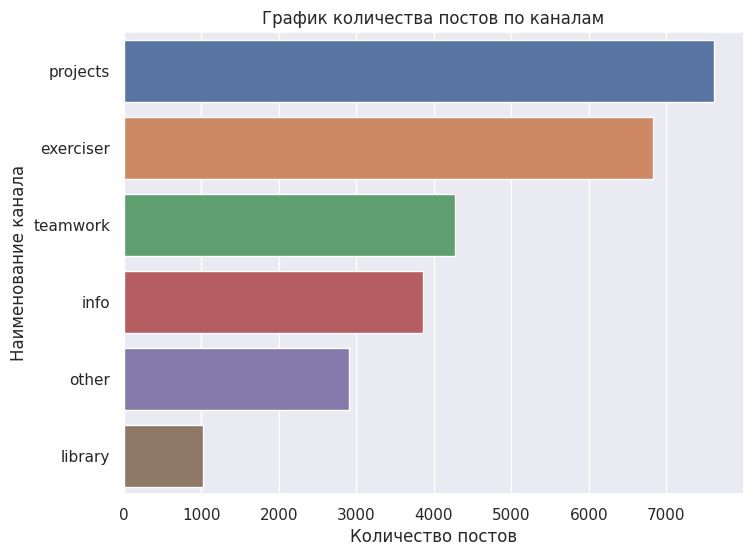

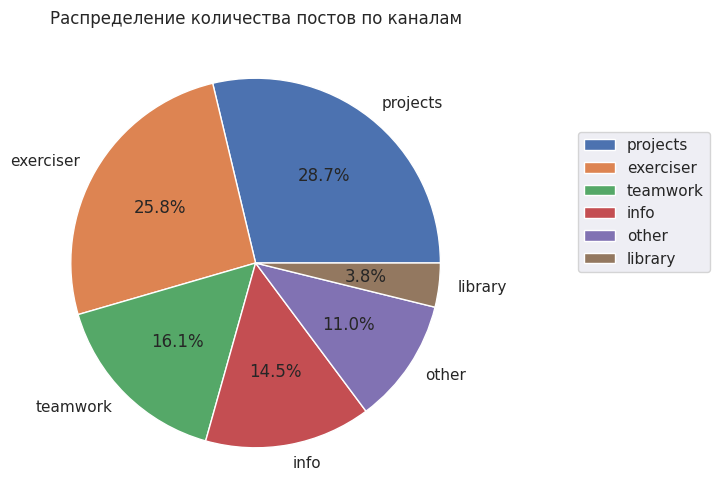

In [ ]:
# анализ поcтов по каналам
posts_channel_groups = df_up.groupby('channel_groups')['ts'].count().reset_index().sort_values(by = 'ts', ascending = False)
display(posts_channel_groups) # количество постов по каналам
# строим диаграмму по количеству постов по каналам
plt.figure(figsize=(8, 6)) # Размер графика
plt.title('График количества постов по каналам') # Название графика
sns.barplot(x='ts', y='channel_groups', data=posts_channel_groups).set(ylabel='Наименование канала', xlabel='Количество постов')
plt.show()
# строим круговую диаграмму:
posts_channel_groups.plot(y='ts', kind="pie", figsize=(6, 6), autopct='%1.1f%%', labels = posts_channel_groups['channel_groups']).set_ylabel('')
plt.legend(bbox_to_anchor=(0.8, 0, 0.7, 0.8)) # Расположение легенды на графике
plt.title('Распределение количества постов по каналам') # Название графика
plt.show()

**Вывод**  
Более половины всех постов приходится на каналы **projects** и **exerciser**.

,channel_groups,thread_ts
4,projects,6076
0,exerciser,4534
5,teamwork,3146
1,info,2322
3,other,2121
2,library,16


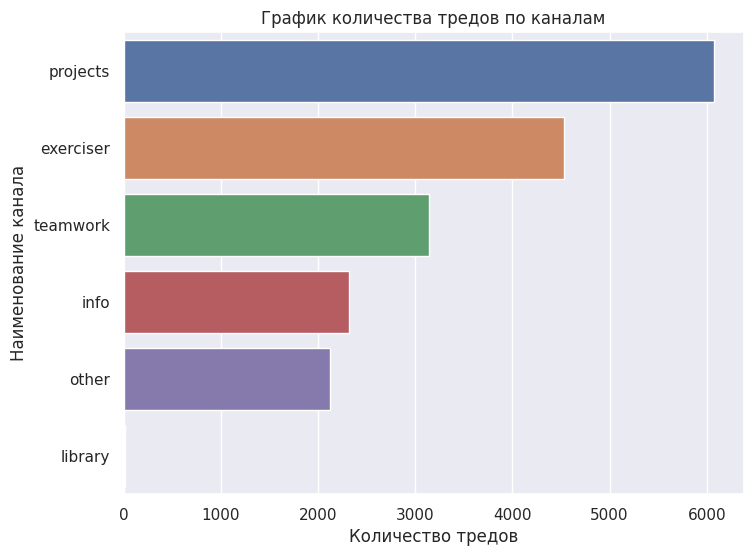

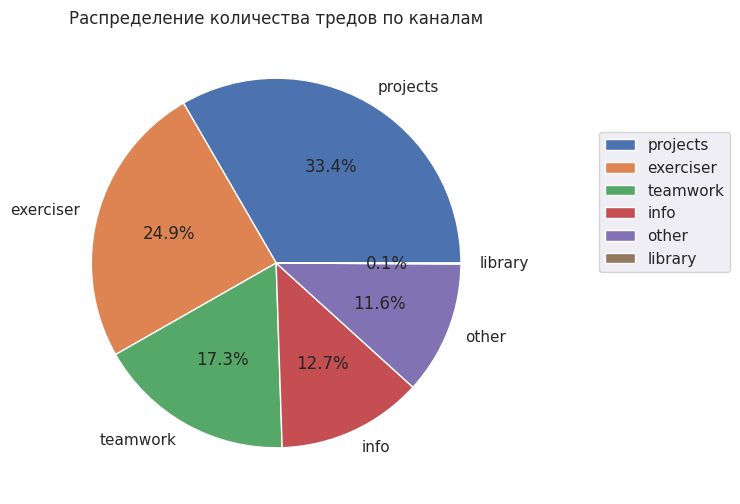

In [ ]:
# анализ тредов по каналам
treds_channel_groups = df_up.groupby('channel_groups')['thread_ts'].count().reset_index().sort_values(by = 'thread_ts', ascending = False)
display(treds_channel_groups) # количество тредов по каналам
# строим диаграмму по количеству тредов по каналам
plt.figure(figsize=(8, 6)) # Размер графика
plt.title('График количества тредов по каналам') # Название графика
sns.barplot(x='thread_ts', y='channel_groups', data=treds_channel_groups).set(ylabel='Наименование канала', xlabel='Количество тредов')
plt.show()
# строим круговую диаграмму:
treds_channel_groups.plot(y='thread_ts', kind="pie", figsize=(6, 6), autopct='%1.1f%%', labels = treds_channel_groups['channel_groups']).set_ylabel('')
plt.legend(bbox_to_anchor=(0.8, 0, 0.7, 0.8)) # Расположение легенды на графике
plt.title('Распределение количества тредов по каналам') # Название графика
plt.show()

**Вывод:**  
Около 60% тредов находятся в каналах **projects**, **exerciser**

,channel_groups,count_reactions
1,info,5054
5,teamwork,2133
3,other,1354
0,exerciser,1266
4,projects,1189
2,library,164


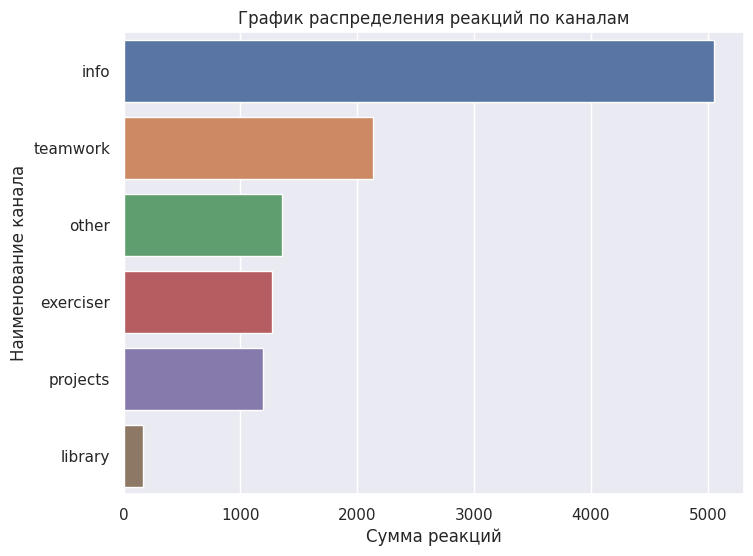

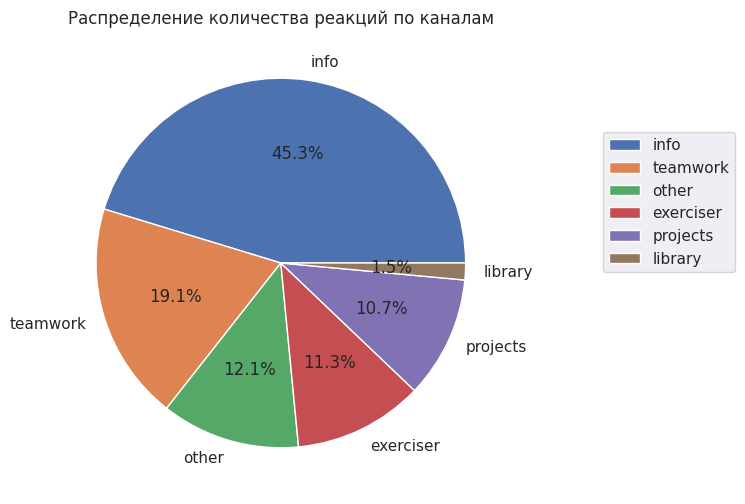

In [ ]:
# анализ количества реакций по каналам
reactions_channel_groups = df_up.groupby('channel_groups')['count_reactions'].sum().reset_index().sort_values(by = 'count_reactions', ascending = False)
display(reactions_channel_groups) # сумма реакций по каналам
# строим диаграмму по сумме реакций по группам
plt.figure(figsize=(8, 6)) # Размер графика
plt.title('График распределения реакций по каналам') # Название графика
sns.barplot(x='count_reactions', y='channel_groups', data=reactions_channel_groups).set(ylabel='Наименование канала', xlabel='Сумма реакций')
plt.show()
# строим круговую диаграмму:
reactions_channel_groups.plot(y='count_reactions', kind="pie", figsize=(6, 6), autopct='%1.1f%%', labels = reactions_channel_groups['channel_groups']).set_ylabel('')
plt.legend(bbox_to_anchor=(0.8, 0, 0.7, 0.8)) # Расположение легенды на графике
plt.title('Распределение количества реакций по каналам') # Название графика
plt.show()

**Вывод:**  
Наибольшее количество реакций в канале **info**, чуть меньше 50%.

,channel_groups,text_len
4,projects,7614
0,exerciser,6830
5,teamwork,4278
1,info,3855
3,other,2906
2,library,1019


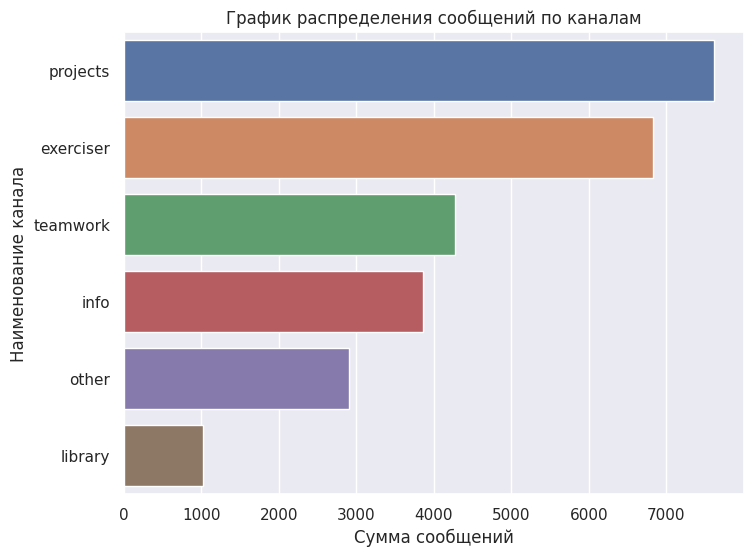

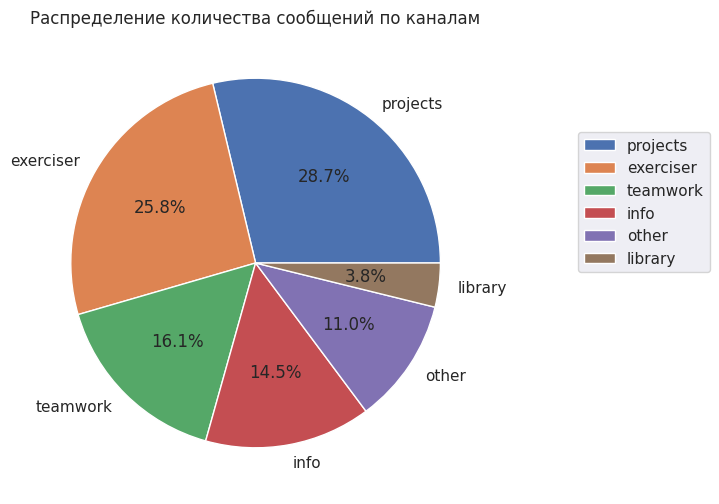

In [ ]:
# анализ количества сообщений по каналам
messages_channel_groups = df_up.groupby('channel_groups')['text_len'].count().reset_index().sort_values(by = 'text_len', ascending = False)
display(messages_channel_groups) # сумма сообщений по каналам
# строим диаграмму по сумме сообщений по группам
plt.figure(figsize=(8, 6)) # Размер графика
plt.title('График распределения сообщений по каналам') # Название графика
sns.barplot(x='text_len', y='channel_groups', data=messages_channel_groups).set(ylabel='Наименование канала', xlabel='Сумма сообщений')
plt.show()
# строим круговую диаграмму:
messages_channel_groups.plot(y='text_len', kind="pie", figsize=(6, 6), autopct='%1.1f%%', labels = messages_channel_groups['channel_groups']).set_ylabel('')
plt.legend(bbox_to_anchor=(0.8, 0, 0.7, 0.8)) # Расположение легенды на графике
plt.title('Распределение количества сообщений по каналам') # Название графика
plt.show()

**Вывод:**  
Более 50% всех сообщений проходится на каналы **projects** и **exerciser**

# Анализ среднего количества постов по когортам (cogorts)

,cogorts,text_len,user,mean_message
1,ds,9815,992,9.89
3,dl,1325,155,8.55
0,da,12912,1524,8.47
5,sql,189,40,4.72
2,de,1981,475,4.17
4,other,280,68,4.12


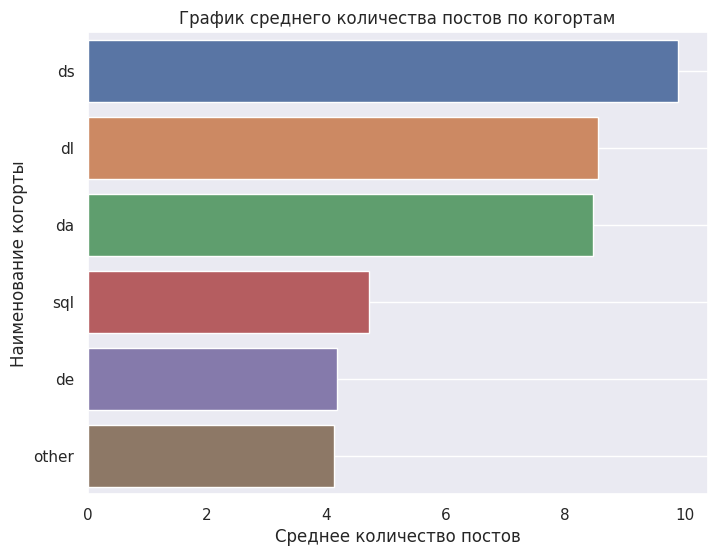

In [ ]:
# анализ среднего количества постов по когортам
# получаем общее количество постов по когортам за вычетом пропущенных позиций по user:
posts_cogorts_text = df_up.query('user != "Nan"').groupby('cogorts')['text_len'].count().reset_index().sort_values(by = 'text_len', ascending = False)
posts_cogorts_user = df_users.groupby('cogorts').agg({'user' : 'nunique'}).reset_index().sort_values(by = 'user', ascending = False)
# объединяем две талицы и получаем среднее кол-во постов
posts_cogorts_mean = posts_cogorts_text.merge(posts_cogorts_user, on = 'cogorts')
posts_cogorts_mean['mean_message'] = (posts_cogorts_mean['text_len'] / posts_cogorts_mean['user'])
posts_cogorts_mean['mean_message'] = posts_cogorts_mean['mean_message'].round(2)
posts_cogorts_mean = posts_cogorts_mean.sort_values(by = 'mean_message', ascending = False)
display(posts_cogorts_mean)
# строим диаграмму по среднему количеству постов по когортам
plt.figure(figsize=(8, 6)) # Размер графика
plt.title('График среднего количества постов по когортам') # Название графика
sns.barplot(x='mean_message', y='cogorts', data=posts_cogorts_mean).set(ylabel='Наименование когорты', xlabel='Среднее количество постов')
plt.grid()
plt.show()

**Вывод:**  
В среднем в когорте **ds** оставляют больше всего постов

,cogorts,count_reactions,user,mean_reactions
3,dl,724,155,4.67
0,da,5832,1524,3.83
4,other,257,68,3.78
1,ds,3016,992,3.04
2,de,1267,475,2.67
5,sql,64,40,1.60


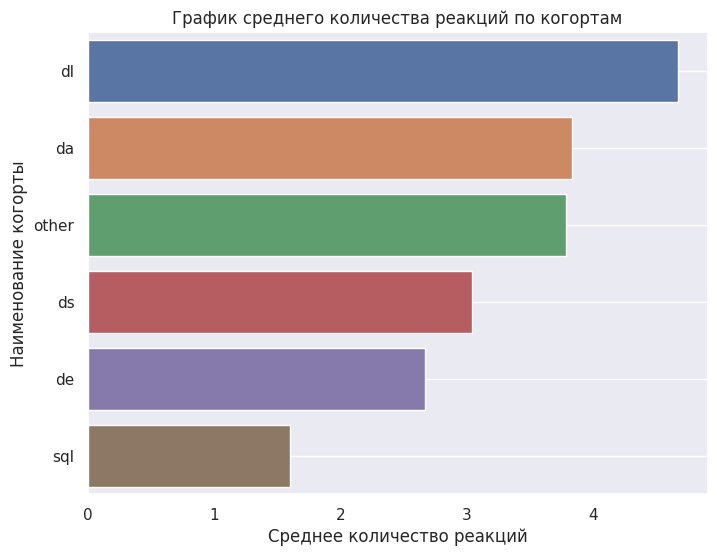

In [ ]:
# анализ среднего количества реакций по когортам
# получаем общее количество реакций по когортам за вычетом пропущенных позиций по user:
reactions_cogorts_text = df_up.query('user != "Nan"').groupby('cogorts')['count_reactions'].sum().reset_index().sort_values(by = 'count_reactions', ascending = False)
# объединяем две талицы и получаем среднее кол-во постов
reactions_cogorts_mean = reactions_cogorts_text.merge(posts_cogorts_user, on = 'cogorts')
reactions_cogorts_mean['mean_reactions'] = reactions_cogorts_mean['count_reactions'] / posts_cogorts_mean['user']
reactions_cogorts_mean['mean_reactions'] = reactions_cogorts_mean['mean_reactions'].round(2)
reactions_cogorts_mean = reactions_cogorts_mean.sort_values(by = 'mean_reactions', ascending = False)
display(reactions_cogorts_mean)
# строим диаграмму по среднему количеству постов по когортам
plt.figure(figsize=(8, 6)) # Размер графика
plt.title('График среднего количества реакций по когортам') # Название графика
sns.barplot(x='mean_reactions', y='cogorts', data=reactions_cogorts_mean).set(ylabel='Наименование когорты', xlabel='Среднее количество реакций')
plt.grid()
plt.show()

**Вывод:**  
Наибольшее среднее количество реакций приходится на когорту **dl**.

# Анализ постов, тредов, реакций по дням недели (ts_week_day)

,ts_week_day,ts
0,1_Понедельник,7906
1,2_Вторник,4141
3,4_Четверг,3813
2,3_Среда,3481
4,5_Пятница,3377
6,7_Воскресенье,2182
5,6_Суббота,1602


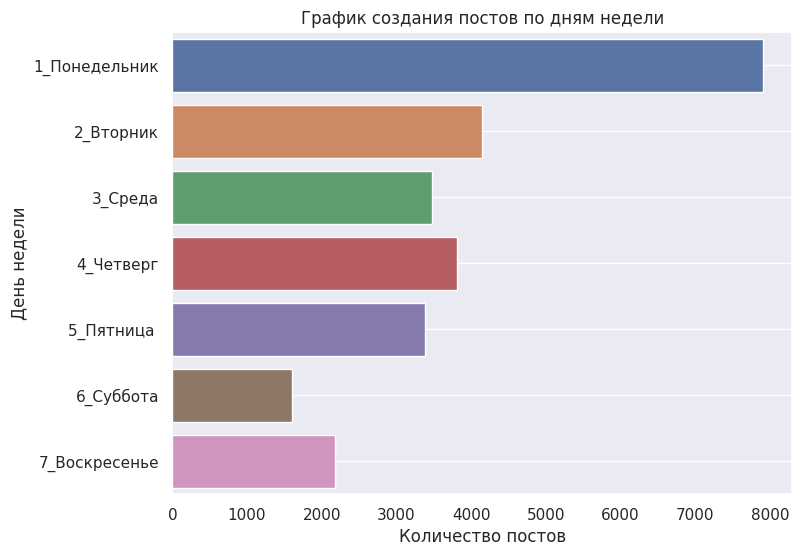

In [ ]:
# анализ постов по дням недели:
posts_week_day = df_up.groupby('ts_week_day')['ts'].count().reset_index().sort_values(by = 'ts', ascending = False)
display(posts_week_day) # количество постов по дням недели
# строим диаграмму по количеству постов по дням недели
plt.figure(figsize=(8, 6)) # Размер графика
plt.title('График создания постов по дням недели') # Название графика
sns.barplot(x='ts', y='ts_week_day', data=posts_week_day.sort_values(by = 'ts_week_day')).set(ylabel='День недели', xlabel='Количество постов')
plt.grid()
plt.show()

**Вывод:**  
Больше всего постов создают по понедельникам

,ts_week_day,thread_ts
0,1_Понедельник,4243
1,2_Вторник,3031
3,4_Четверг,2887
4,5_Пятница,2472
2,3_Среда,2412
6,7_Воскресенье,1726
5,6_Суббота,1444


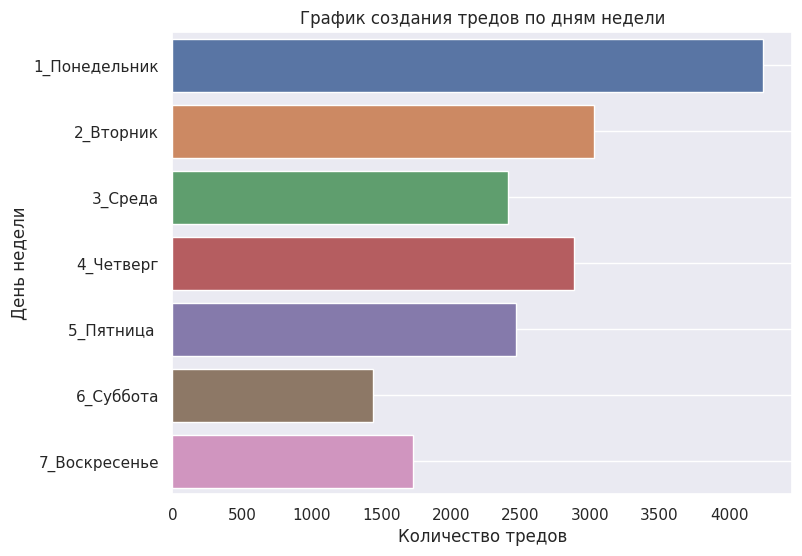

In [ ]:
latest_reply_week_day_thread_ts_count = df_up.groupby('ts_week_day')['thread_ts'].count().reset_index().sort_values(by = 'thread_ts', ascending = False)
display(latest_reply_week_day_thread_ts_count) # количество тредов по дням недели
# строим диаграмму по количеству тредов по дням недели
plt.figure(figsize=(8, 6)) # Размер графика
plt.title('График создания тредов по дням недели') # Название графика
sns.barplot(x='thread_ts', y='ts_week_day', data = latest_reply_week_day_thread_ts_count.sort_values(by = 'ts_week_day')).set(ylabel='День недели', xlabel='Количество тредов')
plt.grid()
plt.show()

**Вывод:**  
Больше всего тредов создают по понедельникам.

,ts_week_day,count_reactions
0,1_Понедельник,2823
3,4_Четверг,1904
1,2_Вторник,1735
2,3_Среда,1506
4,5_Пятница,1470
6,7_Воскресенье,889
5,6_Суббота,833


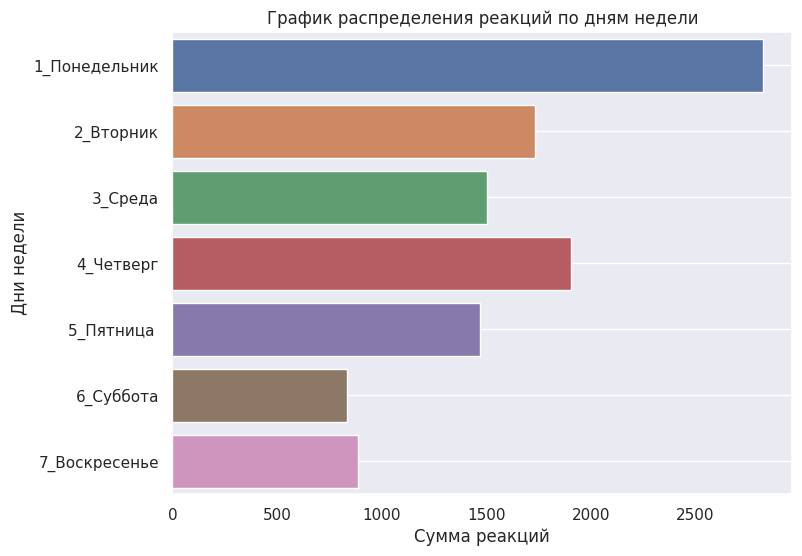

In [ ]:
latest_reply_week_day_count_reactions_sum = df_up.groupby('ts_week_day')['count_reactions'].sum().reset_index().sort_values(by = 'count_reactions', ascending = False)
display(latest_reply_week_day_count_reactions_sum) # сумма реакций по дня недели
# строим диаграмму по сумме реакций по дням недели
plt.figure(figsize=(8, 6)) # Размер графика
plt.title('График распределения реакций по дням недели') # Название графика
sns.barplot(x='count_reactions', y='ts_week_day', data=latest_reply_week_day_count_reactions_sum.sort_values(by = 'ts_week_day')).set(ylabel='Дни недели', xlabel='Сумма реакций')
plt.grid()
plt.show()

**Вывод:**  
Больше всего реакций оставляют по понедельникам.

# Анализ постов, тредов, реакций по часам (ts_hours)

,ts_hours,ts
0,00:00 - 03:00,187
1,03:00 - 06:00,579
2,06:00 - 09:00,6174
3,09:00 - 12:00,5503
4,12:00 - 15:00,5952
5,15:00 - 18:00,4476
6,18:00 - 21:00,2963
7,21:00 - 00:00,668


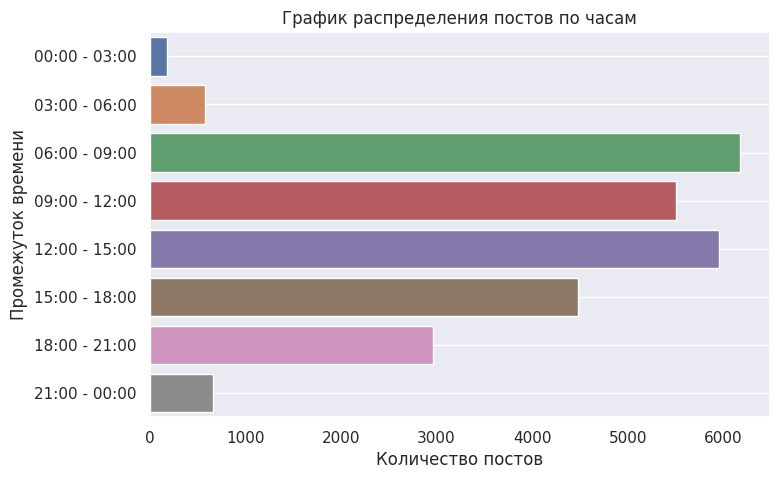

In [ ]:
# анализ по latest_reply_hours (часам): ts, thread_ts, latest_reply, count_reactions
df_up['ts_hours'] = df_up['ts_hours'].astype('str')
latest_reply_hours_ts_count = df_up.groupby('ts_hours')['ts'].count().reset_index().sort_values(by = 'ts_hours')
display(latest_reply_hours_ts_count) # количество постов по часам
# строим диаграмму по количеству постов по часам
plt.figure(figsize=(8, 5)) # Размер графика
plt.title('График распределения постов по часам') # Название графика
sns.barplot(x='ts', y='ts_hours', data=latest_reply_hours_ts_count).set(ylabel='Промежуток времени', xlabel='Количество постов')
plt.grid()
plt.show()

**Вывод:**  
В промежутке времени с 6.00 по 15.00 создается больше всего постов.

,ts_hours,thread_ts
4,12:00 - 15:00,3984
2,06:00 - 09:00,3577
3,09:00 - 12:00,3548
5,15:00 - 18:00,3244
6,18:00 - 21:00,2523
7,21:00 - 00:00,638
1,03:00 - 06:00,535
0,00:00 - 03:00,166


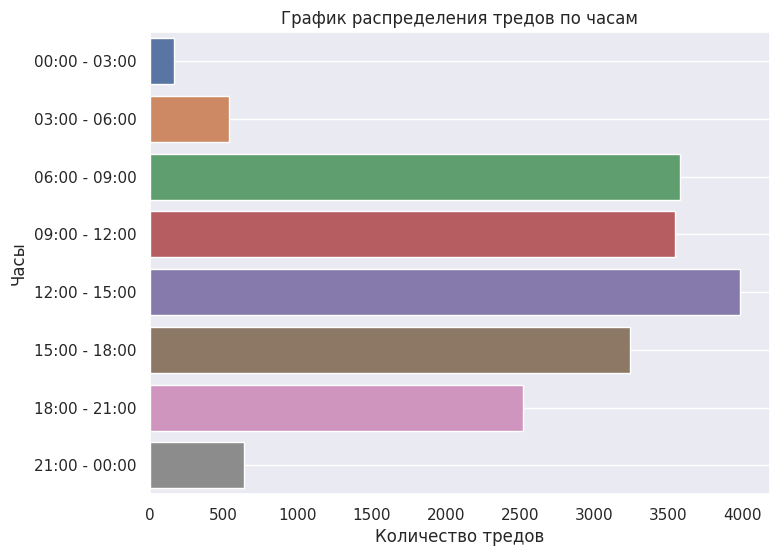

In [ ]:
latest_reply_hours_thread_ts_count = df_up.groupby('ts_hours')['thread_ts'].count().reset_index().sort_values(by = 'thread_ts', ascending = False).query('ts_hours != "nan"')
display(latest_reply_hours_thread_ts_count) # количество тредов по часам
# строим диаграмму по количеству тредов по часам
plt.figure(figsize=(8, 6)) # Размер графика
plt.title('График распределения тредов по часам') # Название графика
sns.barplot(x='thread_ts', y='ts_hours', data = latest_reply_hours_thread_ts_count.sort_values(by = 'ts_hours')).set(ylabel='Часы', xlabel='Количество тредов')
plt.grid()
plt.show()

**Вывод:**  
Больше всего тредов создается в промежутке времени с 6.00 по 18.00.

,ts_hours,count_reactions
2,06:00 - 09:00,2732
4,12:00 - 15:00,2688
3,09:00 - 12:00,2398
5,15:00 - 18:00,1775
6,18:00 - 21:00,1001
1,03:00 - 06:00,301
7,21:00 - 00:00,223
0,00:00 - 03:00,42


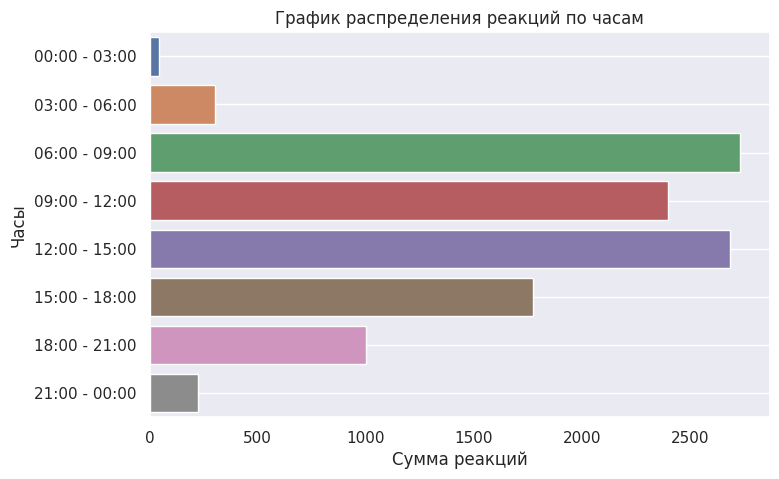

In [ ]:
latest_reply_hours_count_reactions_sum = df_up.groupby('ts_hours')['count_reactions'].sum().reset_index()\
.sort_values(by = 'count_reactions', ascending = False)
display(latest_reply_hours_count_reactions_sum) # сумма реакций по часам
# строим диаграмму по сумме реакций по часам
plt.figure(figsize=(8, 5)) # Размер графика
plt.title('График распределения реакций по часам') # Название графика
sns.barplot(x='count_reactions', y='ts_hours', data=latest_reply_hours_count_reactions_sum.sort_values(by = 'ts_hours')).set(ylabel='Часы', xlabel='Сумма реакций')
plt.grid()
plt.show()

**Вывод:**
Больше всего реакций оставляют в промежутке времени с 6.00 по 15.00

# Анализ вхождения и выхода из каналов

,ts_week_day,ts_hours,subtype
0,1_Понедельник,03:00 - 06:00,24
1,1_Понедельник,06:00 - 09:00,167
2,1_Понедельник,09:00 - 12:00,331
3,1_Понедельник,12:00 - 15:00,105
4,1_Понедельник,15:00 - 18:00,142
5,1_Понедельник,18:00 - 21:00,40
6,2_Вторник,06:00 - 09:00,69
7,2_Вторник,09:00 - 12:00,70
8,2_Вторник,12:00 - 15:00,224
9,2_Вторник,15:00 - 18:00,46


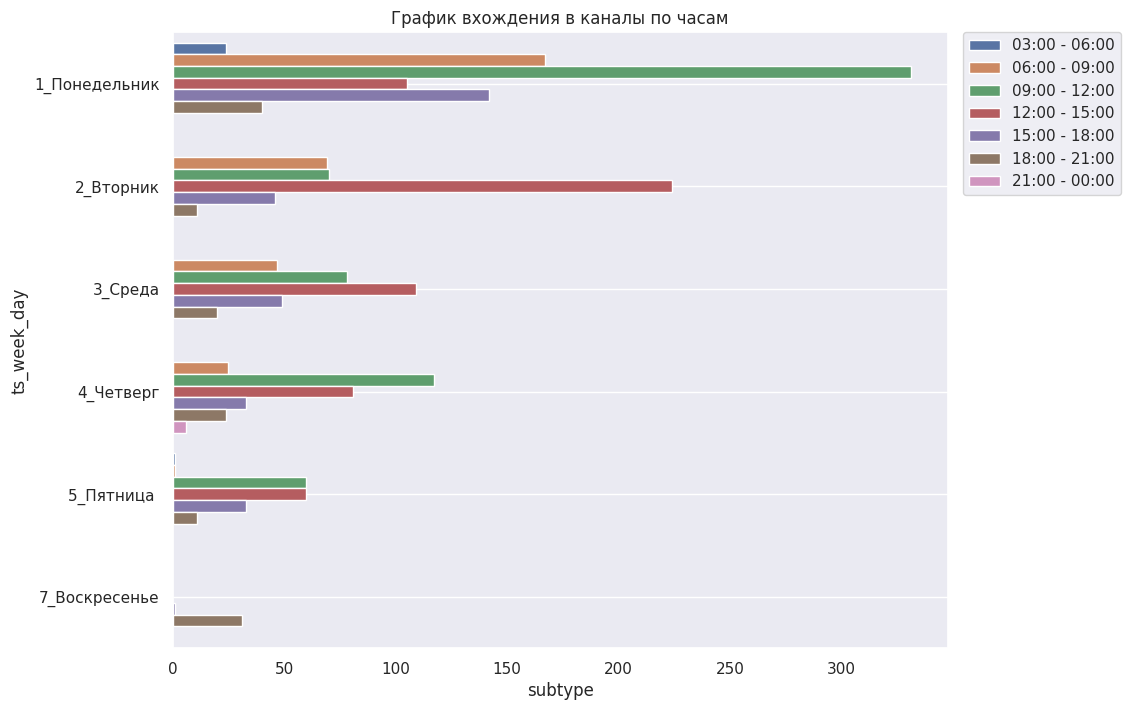

In [ ]:
# когда чаще всего заходили (subtype) по дням и часам
channel_join_week_day_hours = df_up.query('subtype == "channel_join"').pivot_table(index = ['ts_week_day', 'ts_hours'], values = 'subtype', aggfunc = 'count')\
.reset_index()#.sort_values(by = ['subtype'], ascending = False)
display(channel_join_week_day_hours.head(50))
# строим график
plt.figure(figsize=(10, 8)) # Размер графика
plt.title('График вхождения в каналы по часам') # Название графика
sns.barplot(channel_join_week_day_hours, x='subtype', y = 'ts_week_day', hue = 'ts_hours')
plt.legend(bbox_to_anchor = ( 1.02 , 1 ), loc = 'upper left', borderaxespad = 0) # положение легенды
plt.grid()

**Вывод:**
Наибольшее количество входов в каналы приходится на понедельник в интервате времени с 6.00 по 12.00. В субботу в каналы не заходят вовсе.

,ts_week_day,ts_hours,subtype
3,1_Понедельник,09:00 - 12:00,347
4,1_Понедельник,12:00 - 15:00,288
2,1_Понедельник,06:00 - 09:00,209
19,4_Четверг,09:00 - 12:00,207
26,5_Пятница,12:00 - 15:00,178
14,3_Среда,09:00 - 12:00,178
16,3_Среда,15:00 - 18:00,162
15,3_Среда,12:00 - 15:00,143
7,2_Вторник,06:00 - 09:00,140
35,7_Воскресенье,15:00 - 18:00,136


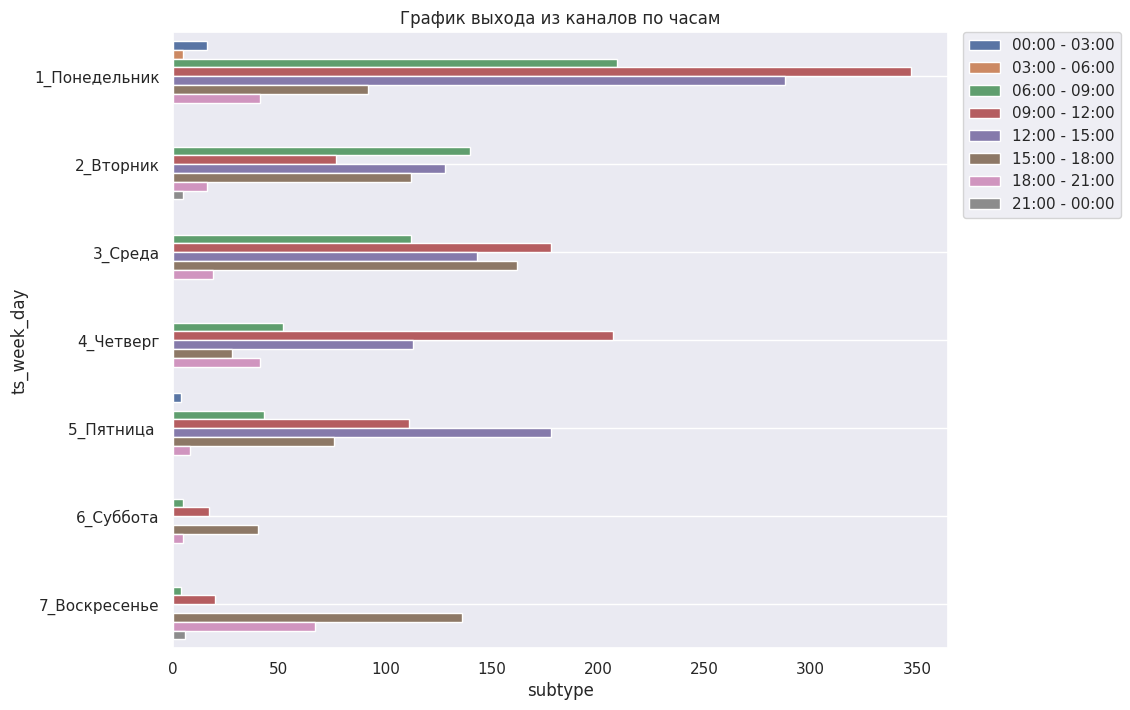

In [ ]:
# когда чаще всего выходили (subtype) по дням и часам
channel_leave_week_day_hours = df_up.query('subtype == "channel_leave"').pivot_table(index = ['ts_week_day', 'ts_hours'], values = 'subtype', aggfunc = 'count')\
.reset_index().sort_values(by = ['subtype', 'ts_week_day'], ascending = False)
display(channel_leave_week_day_hours.head(10))
# строим график
plt.figure(figsize=(10, 8)) # Размер графика
plt.title('График выхода из каналов по часам') # Название графика
sns.barplot(channel_leave_week_day_hours.sort_values(by = ['ts_week_day', 'ts_hours']), x='subtype', y = 'ts_week_day', hue = 'ts_hours');
plt.legend(bbox_to_anchor = ( 1.02 , 1 ), loc = 'upper left', borderaxespad = 0)
plt.grid()

**Вывод:**
Основная масса уходит из каналов к 15.00

In [ ]:
# соединяем входы и выходы
df_merged = pd.merge(channel_join_week_day_hours, channel_leave_week_day_hours, on=['ts_week_day', 'ts_hours'], how = 'outer').sort_values(by = ['ts_week_day', 'ts_hours']).fillna(0)
#df_merged

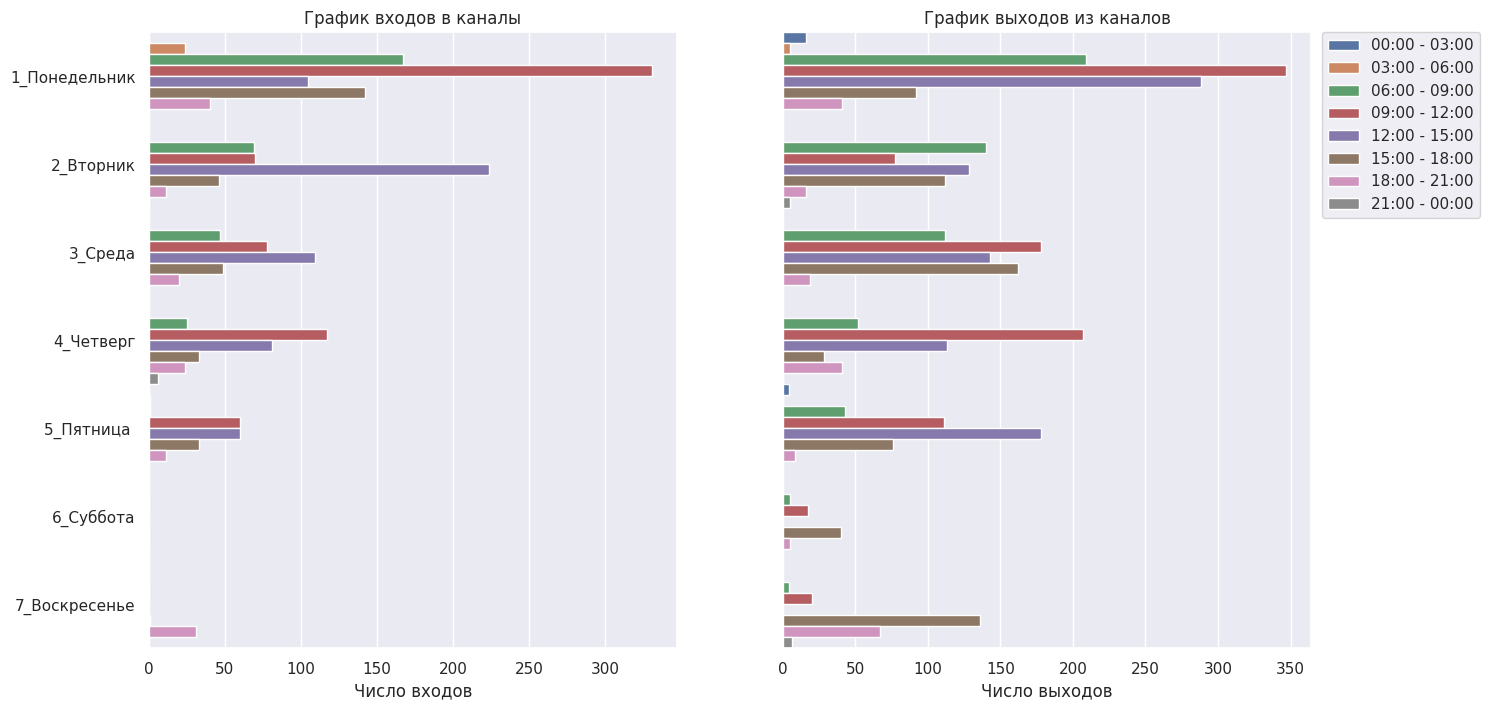

In [ ]:
#  строим два графика: вхождение и выход из канала
fig,axes = plt.subplots(1,2, figsize=(15, 8))
pl1 = sns.barplot(data = df_merged.sort_values(by = ['ts_week_day', 'ts_hours']), x='subtype_x', y = 'ts_week_day', hue = 'ts_hours', ax=axes[0], width=1)
pl1.title.set_text('График входов в каналы')
pl1.legend_.remove()
pl1.set(ylabel=None)
pl1.set_xlabel('Число входов')
pl2 = sns.barplot(data = df_merged.sort_values(by = ['ts_week_day', 'ts_hours']), x='subtype_y', y = 'ts_week_day', hue = 'ts_hours', ax=axes[1], width=1)
pl2.title.set_text('График выходов из каналов')
pl2.set(yticklabels=[], ylabel=None)
pl2.set_xlabel('Число выходов')
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0);# перемещаем легенду


# Общий вывод

**ОБЩИЙ ВЫВОД:**  
В ходе работы был проанализирована активность в чатах Пачки и Slack и выявлены следующие закономерности:  

 - на каналы projects и exerciser приходится 54,5% всех сообщений;  
 - наибольшее количество реакций в канале info 45,3% всех реакций;
 - самые активные когорты по среднему количеству постов ds, dl, da;  
 - больше всего реакций оставляют пользователи когорт dl, da;
 - понедельник - самый активный день, здесь больше всего создаётся постов тредов и ответов;  
 - основная активность по созданию постов, ответов и реакций приходится на рабочее время 6.00 - 18.00;  
 - больше всего пользователей заходит в каналы в понедельник с 9.00 до 12.00;  
 - поскольку заходит больше всего пользователей по понедельникам, то и выходит больше всего по понедельникам в промежутке времени 9.00 - 15.00.  

**РЕКОМЕНДАЦИИ:**  
Для публикации постов и привлечения к ним максимального внимания рекомендуется их размещать по понедельникам в интервале времени с 6.00 до 9.00. Именно в это время пользователи начинают посещать каналы и одновременно выходить из каналом. К 15.00 большинство пользователей выходят из чатов.